# Deploying Large Language Model with multiple unmerged LoRA adapters on Amazon SageMaker

In this demo notebook, we demonstrate how to use AWS Python SDK (boto3) to deploy Llama-2-7B with 3 unmerged LoRA adapters

We begin by installing and upgrading necessary packages. Restart the kernel after executing the cell below for the first time.

In [ ]:
%pip install sagemaker boto3 huggingface_hub --upgrade --quiet --no-warn-conflicts

In [ ]:
import json
import boto3
import sagemaker
import huggingface_hub

**Baseline SageMaker setup**

In [ ]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
region = sess._region_name  # region name of the current SageMaker Studio environment

sm_client = boto3.client("sagemaker")  # client to intreract with SageMaker
smr_client = boto3.client("sagemaker-runtime")  # client to intreract with SageMaker Endpoints

print(f"SageMaker version: {sagemaker.__version__}")

## Serving LoRA-based Llama 3 adapters with high performance on SageMaker 

This notebook will demonstrate how you can deploy multiple fine-tuned LoRA adapters with a single base model copy on SageMaker using the DJL Serving Large Model Inference DLC. LoRA (Low Rank Adapters) is a powerful technique for fine-tuning large language models. This technique significantly reduces the number of trainable parameters compared to traditional fine-tuning while achieving comparable or superior performance. You can learn more about the LoRA technique in this paper.

A major benefit of LoRA is that the fine-tuned adapters can easily be added to and removed from the base model, which makes switching adapters pretty cheap and viable at runtime. In this notebook we will show how you can deploy a SageMaker endpoint with a single base model and multiple LoRA adapters, and change adapters for different requests.

Since LoRA adapters are much smaller than the size of a base model (can realistically be 100x-1000x smaller), we can deploy an endpoint with a single base model and multiple LoRA adapters using much less hardware than deploying an equivalent number of fully fine-tuned models.

In this notebook, we deploy llama3 as the base model and 3 LoRA adapters fine tuned for a specific language on SageMaker as shown below by leveraging the [SageMaker Large Model Inference Container](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers).

The LMI container offers the out-of-box integration with SageMaker for hosting multiple LoRA adapters with higher performance (low latency and high throughput) using the [vLLM](https://docs.vllm.ai/en/latest/models/lora.html) library that uses [S-LORA](https://github.com/S-LoRA/S-LoRA) and [Punica](https://arxiv.org/pdf/2310.18547.pdf). S-LoRA stores all adapters in the main memory and fetches the adapters used by the currently running queries to the GPU memory. To efficiently use the GPU memory and reduce fragmentation, S-LoRA proposes Unified Paging. Unified Paging uses a unified memory pool to manage dynamic adapter weights with different ranks and KV cache tensors with varying sequence lengths. Additionally, S-LoRA employs a novel tensor parallelism strategy and highly optimized custom CUDA kernels for heterogeneous batching of LoRA computation. Collectively, these features enable S-LoRA to serve thousands of LoRA adapters on a single GPU or across multiple GPUs with a small overhead.

Below diagram shows the Multi LoRA-Adapter serving stack of LMI container on SageMaker

### License agreement
 - View license information https://huggingface.co/meta-llama before using the model.
 - This notebook is a sample notebook and not intended for production use. Please refer to the licence at https://github.com/aws/mit-0. 

In [ ]:
inference_image = sagemaker.image_uris.retrieve(framework="djl-lmi", region=region, version="0.29.0")

### Solution Overview

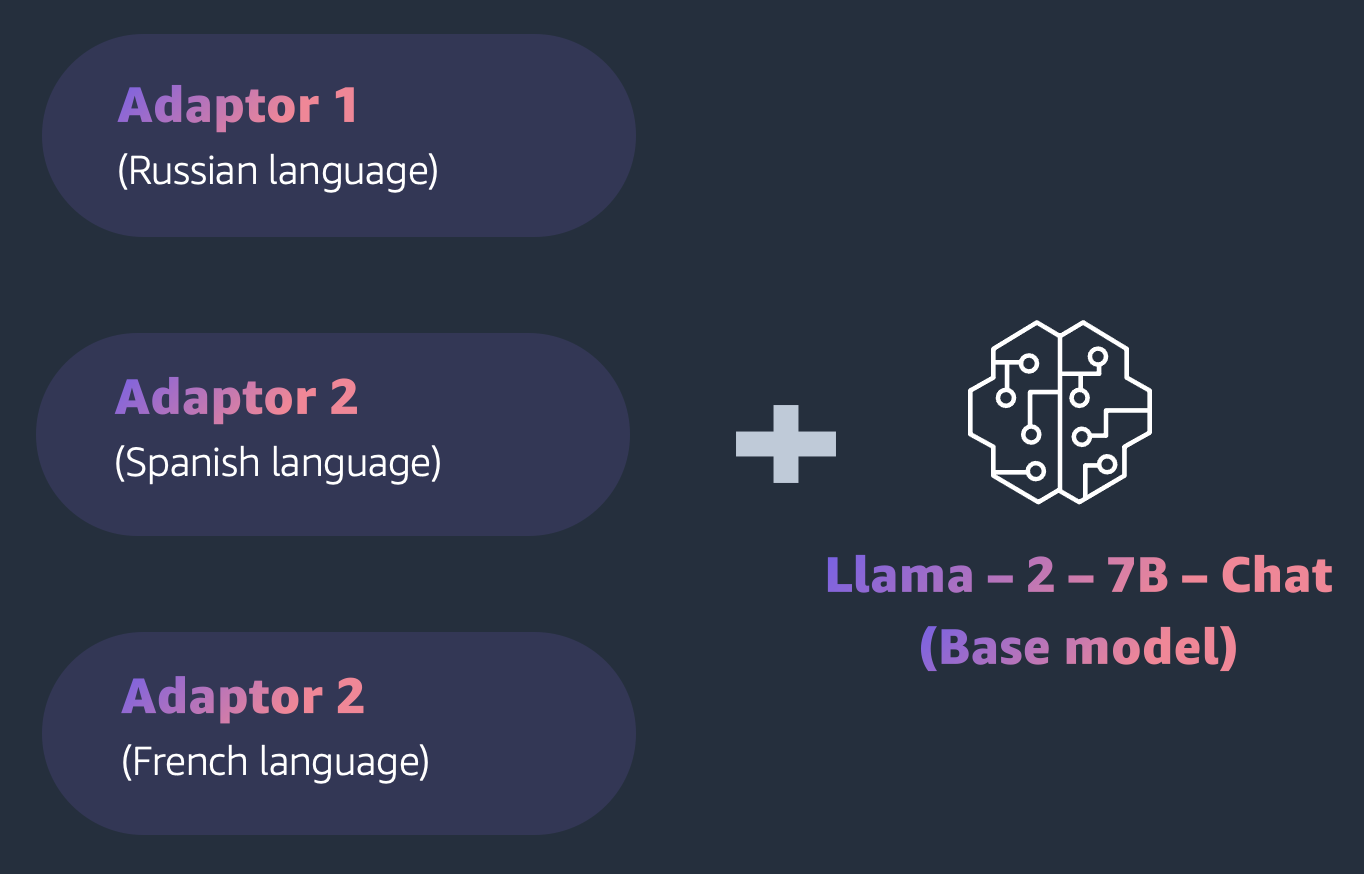

We will be deploying an endpoint with 3 LoRA adapters. These are the models we will be using:

Base Model: Llama-2-7B-Chat-fp16
LoRA Fine Tuned Adapter 1: https://huggingface.co/UnderstandLing/llama-2-7b-chat-ru
LoRA Fine Tuned Adapter 2: https://huggingface.co/UnderstandLing/llama-2-7b-chat-es
LoRA Fine Tuned Adapter 3: https://huggingface.co/UnderstandLing/llama-2-7b-chat-fr

The core structure to cover here is the model directory. We include both the base model and LoRA adapters in the model directory like this:

```
|- model_dir
    |- adapters/
        |--- <adapter_1>/
        |--- <adapter_2>/
        |--- ...
        |--- <adapter_n>/
    |- serving.properties
    |- model.py (optional)

```

It is also possible to have model files located in a separate s3 bucket by specifying that location using an s3 `option.model_id` in the serving.properties. In this case, the adapters directory can be located either alongside the `serving.properties` or alongside the model files in s3.

Each of the adapters in the `adapters` directory contains the LoRA adapter artifacts. Typically there are two files: `adapter_model.bin` and `adapter_config.json` which are the adapter weights and adapter configuration respectively. These are typically obtained from the Peft library via the `PeftModel.save_pretrained()` method.

In [ ]:
!rm -rf lora-multi-adapter
!mkdir -p lora-multi-adapter/adapters

In [ ]:
huggingface_hub.snapshot_download("UnderstandLing/llama-2-7b-chat-ru", local_dir="lora-multi-adapter/adapters/ru")

In [ ]:
huggingface_hub.snapshot_download("UnderstandLing/llama-2-7b-chat-es", local_dir="lora-multi-adapter/adapters/es")

In [ ]:
huggingface_hub.snapshot_download("UnderstandLing/llama-2-7b-chat-fr", local_dir="lora-multi-adapter/adapters/fr")

In [ ]:
%%writefile lora-multi-adapter/serving.properties
option.model_id=TheBloke/Llama-2-7B-Chat-fp16
option.max_rolling_batch_size=16
option.rolling_batch=lmi-dist
option.max_rolling_batch_prefill_tokes=2048
option.max_model_len=2048
option.enable_lora=true
option.gpu_memory_utilization=0.8
option.max_lora_rank=64
option.max_cpu_loras=4

In [ ]:
!rm -rf lora-multi-adapter/.ipynb_checkpoints
!rm -rf lora-multi-adapter/adapters/ru/.cache
!rm -rf lora-multi-adapter/adapters/ru/.gitattributes
!rm -rf lora-multi-adapter/adapters/es/.cache
!rm -rf lora-multi-adapter/adapters/es/.gitattributes
!rm -rf lora-multi-adapter/adapters/fr/.cache
!rm -rf lora-multi-adapter/adapters/fr/.gitattributes

In [ ]:
s3_code_prefix = "cost_workshop/multi-lora/Llama-2-7b-fp16"
s3_adapters_location = sess.upload_data("lora-multi-adapter", bucket, s3_code_prefix)
print(s3_adapters_location)

In [ ]:
model_name = sagemaker.utils.name_from_base("cost-workshop-LoRA")
endpoint_config_name = model_name
endpoint_name = model_name

In [ ]:
create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": inference_image,
        "ModelDataSource": {
            'S3DataSource': {
                'S3Uri': s3_adapters_location + "/",
                'S3DataType': 'S3Prefix',
                'CompressionType': 'None',
            }
        }
    }
)
model_arn = create_model_response["ModelArn"]
print(f"Created Model: {model_arn}")

In [ ]:
endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g5.2xlarge",
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": 900,
            "RoutingConfig": {
                'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'
            },
        },
    ],
)
endpoint_config_response

In [ ]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName = endpoint_name, EndpointConfigName = endpoint_config_name
)
sess.wait_for_endpoint(endpoint_name)

In [ ]:
payload = {
    "inputs": "¿Qué es Amazon SageMaker?",
    "adapters": ["es"],
    "parameters": {
        "max_new_tokens": 128,
        "top_p": 0.9,
        "temperature": 0.6,
    },
}

response_model = smr_client.invoke_endpoint(
    EndpointName = endpoint_name,
    Body = json.dumps(payload),
    ContentType = "application/json",
)

response = json.loads(response_model["Body"].read().decode("utf8"))["generated_text"]
print("\n---", response, "\n---\n")

In [ ]:
payload = {
    "inputs": "Что такое Amazon SageMaker?",
    "adapters": ["ru"],
    "parameters": {
        "max_new_tokens": 128,
        "top_p": 0.9,
        "temperature": 0.6,
    },
}

response_model = smr_client.invoke_endpoint(
    EndpointName = endpoint_name,
    Body = json.dumps(payload),
    ContentType = "application/json",
)

response = json.loads(response_model["Body"].read().decode("utf8"))["generated_text"]
print("\n---", response, "\n---\n")

In [ ]:
payload = {
    "inputs": "Qu'est-ce qu'Amazon SageMaker?",
    "adapters": ["fr"],
    "parameters": {
        "max_new_tokens": 128,
        "top_p": 0.9,
        "temperature": 0.6,
    },
}

response_model = smr_client.invoke_endpoint(
    EndpointName = endpoint_name,
    Body = json.dumps(payload),
    ContentType = "application/json",
)

response = json.loads(response_model["Body"].read().decode("utf8"))["generated_text"]
print("\n---", response, "\n---\n")

**Do NOT forget to delete unused endpoint to avoid unnessary charges to your account**

In [ ]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_config_name)
sess.delete_model(model_name)